In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from timm import create_model
import cv2
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=['NT_epithelial','NT_immune','NT_stroma','TP_in_situ','TP_invasive']
class_nm='TP_invasive'
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:36: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [2]:
img_path='../../data/area_segmentation/BR_class/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image','/'+class_nm) for i in img_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.2,random_state=42)

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),2,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),2,img_size,img_size),dtype=torch.float32)
for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    np_mask=tf(Image.open(train_mask_list[i]))
    train_mask[i,1]=np_mask
    train_mask[i,0]=1-np_mask
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    np_mask=tf(Image.open(test_mask_list[i]))
    test_mask[i,1]=np_mask
    test_mask[i,0]=1-np_mask


100%|██████████| 780/780 [00:42<00:00, 18.47it/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = smp.UnetPlusPlus(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset) 
    ).to(device)
def dice_loss(pred, target, num_classes=2):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()

# summary(model,(batch_size,3,img_size,img_size))

epoch: 1/1000 Step: 1559 dice_loss : 0.4921 dice_score: 0.5079: 100%|██████████| 1558/1558 [12:27<00:00,  2.08it/s]
test epoch: 1/1000 Step: 391 dice_loss : 0.4749  dice_score: 0.5251: 100%|██████████| 390/390 [00:54<00:00,  7.16it/s]
epoch: 2/1000 Step: 1559 dice_loss : 0.4768 dice_score: 0.5232: 100%|██████████| 1558/1558 [12:27<00:00,  2.08it/s]
test epoch: 2/1000 Step: 391 dice_loss : 0.4718  dice_score: 0.5282: 100%|██████████| 390/390 [00:54<00:00,  7.21it/s]
epoch: 3/1000 Step: 1559 dice_loss : 0.4721 dice_score: 0.5279: 100%|██████████| 1558/1558 [12:32<00:00,  2.07it/s]
test epoch: 3/1000 Step: 391 dice_loss : 0.4806  dice_score: 0.5194: 100%|██████████| 390/390 [00:55<00:00,  7.08it/s]
epoch: 4/1000 Step: 1559 dice_loss : 0.4702 dice_score: 0.5298: 100%|██████████| 1558/1558 [12:20<00:00,  2.10it/s]
test epoch: 4/1000 Step: 391 dice_loss : 0.4728  dice_score: 0.5272: 100%|██████████| 390/390 [00:54<00:00,  7.12it/s]
epoch: 5/1000 Step: 1559 dice_loss : 0.4678 dice_score: 0.53

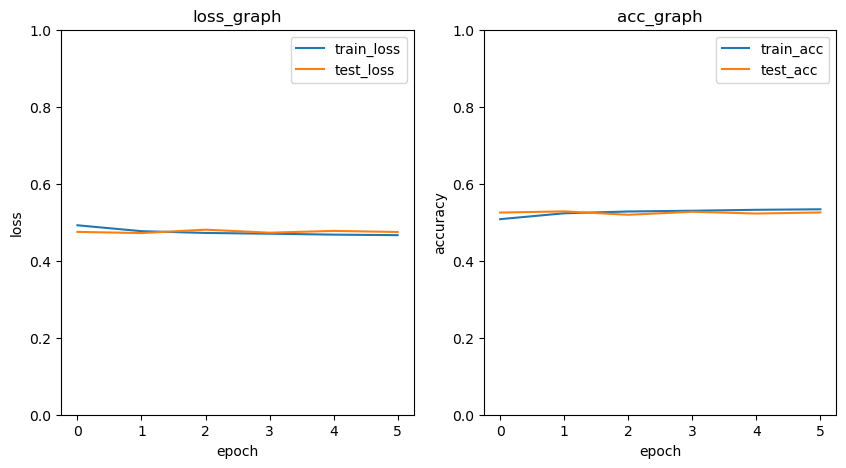

epoch: 7/1000 Step: 1559 dice_loss : 0.4662 dice_score: 0.5338: 100%|██████████| 1558/1558 [12:21<00:00,  2.10it/s]
test epoch: 7/1000 Step: 391 dice_loss : 0.4753  dice_score: 0.5247: 100%|██████████| 390/390 [00:54<00:00,  7.18it/s]
epoch: 8/1000 Step: 1559 dice_loss : 0.4649 dice_score: 0.5351: 100%|██████████| 1558/1558 [12:17<00:00,  2.11it/s]
test epoch: 8/1000 Step: 391 dice_loss : 0.4708  dice_score: 0.5292: 100%|██████████| 390/390 [00:53<00:00,  7.25it/s]
epoch: 9/1000 Step: 1559 dice_loss : 0.4641 dice_score: 0.5359: 100%|██████████| 1558/1558 [12:24<00:00,  2.09it/s]
test epoch: 9/1000 Step: 391 dice_loss : 0.4736  dice_score: 0.5264: 100%|██████████| 390/390 [00:57<00:00,  6.76it/s]
epoch: 10/1000 Step: 1559 dice_loss : 0.4635 dice_score: 0.5365: 100%|██████████| 1558/1558 [12:23<00:00,  2.09it/s]
test epoch: 10/1000 Step: 391 dice_loss : 0.4800  dice_score: 0.5200: 100%|██████████| 390/390 [00:55<00:00,  7.03it/s]
epoch: 11/1000 Step: 1559 dice_loss : 0.4632 dice_score: 0

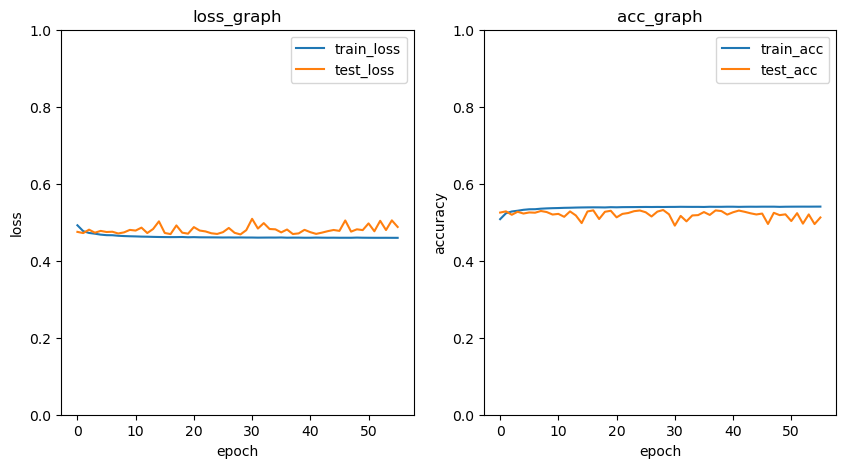

epoch: 57/1000 Step: 1559 dice_loss : 0.4595 dice_score: 0.5405: 100%|██████████| 1558/1558 [12:15<00:00,  2.12it/s]
test epoch: 57/1000 Step: 391 dice_loss : 0.4738  dice_score: 0.5262: 100%|██████████| 390/390 [00:54<00:00,  7.19it/s]
epoch: 58/1000 Step: 1559 dice_loss : 0.4595 dice_score: 0.5405: 100%|██████████| 1558/1558 [12:15<00:00,  2.12it/s]
test epoch: 58/1000 Step: 391 dice_loss : 0.4835  dice_score: 0.5165: 100%|██████████| 390/390 [00:54<00:00,  7.19it/s]
epoch: 59/1000 Step: 1559 dice_loss : 0.4594 dice_score: 0.5406: 100%|██████████| 1558/1558 [12:15<00:00,  2.12it/s]
test epoch: 59/1000 Step: 391 dice_loss : 0.4732  dice_score: 0.5268: 100%|██████████| 390/390 [00:54<00:00,  7.15it/s]
epoch: 60/1000 Step: 1559 dice_loss : 0.4596 dice_score: 0.5404: 100%|██████████| 1558/1558 [12:15<00:00,  2.12it/s]
test epoch: 60/1000 Step: 391 dice_loss : 0.4882  dice_score: 0.5118: 100%|██████████| 390/390 [00:53<00:00,  7.22it/s]
epoch: 61/1000 Step: 1559 dice_loss : 0.4594 dice_sc

In [5]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/areaSeg/BR_'+class_nm+'.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')